In [14]:
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from scipy.io import wavfile
from scipy.interpolate import interp1d
import numpy as np
import seaborn as sns
import os

sns.set_theme()
sns.set_style("darkgrid")

In [15]:
fs, p = wavfile.read('sonido-presion/presion_segmento_1.wav')
fs, b = wavfile.read('sonido-presion/beta_segmento_1.wav')
fs, s_m = wavfile.read('sonido-presion/sonido_segmento_1.wav')
fs, s_s = wavfile.read('sonido-presion/simulacion_segmento_1.wav')


In [16]:
#normalizo
p = p.astype(np.float32)
s_m = s_m / max(s_m)
s_s = s_s / max(s_s)


In [17]:

dt = 1/fs
N  = len(p)
t = np.arange(0, N) * dt

print(f'frec muestreo: {fs} \n dt muestreo: {dt} \n tiempo total de medición {t[-1]} s')

frec muestreo: 44150 
 dt muestreo: 2.2650056625141562e-05 
 tiempo total de medición 0.8827859569648924 s


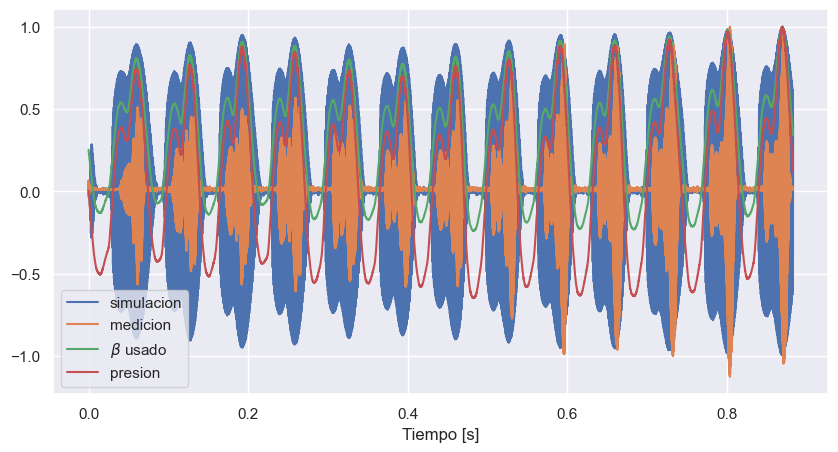

In [18]:
plt.figure(figsize=(10,5))

plt.plot(t,s_s, label = 'simulacion')
plt.plot(t,s_m, label = 'medicion')
plt.plot(t,b/max(b), label = r'$\beta$ usado')
plt.plot(t,p/max(p), label = r'presion')
plt.xlabel('Tiempo [s]')
plt.legend()

### Discusión: normalización de $\beta$

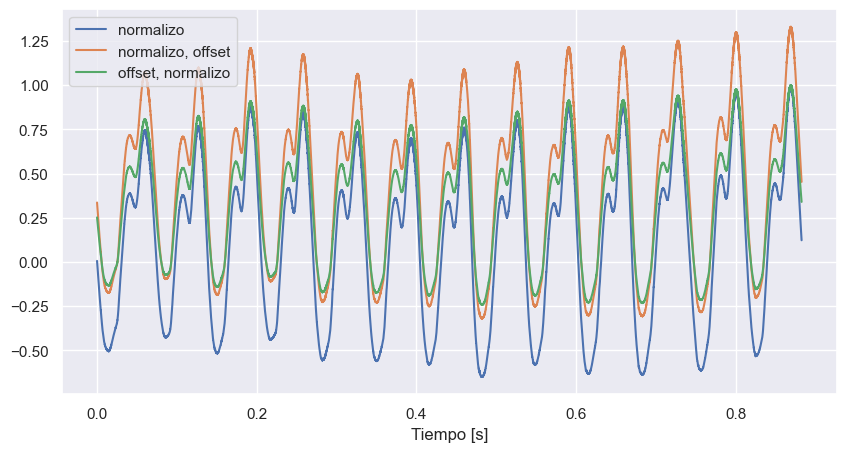

In [7]:
plt.figure(figsize=(10,5))

#plt.plot(t,((p/max(p)) + 0.33)/max((p/max(p)) + 0.33), label = r'normalizo, offset, normalizo')
#plt.plot(t,(p + 9000) / max(p + 9000), label = r'offset, normalizo')
plt.plot(t, p/ max(p), label = 'normalizo')
plt.plot(t,(p/max(p)) + 0.33, label = r'normalizo, offset')
plt.plot(t,(p + 9000) / max(p + 9000), label = r'offset, normalizo')
plt.xlabel('Tiempo [s]')
plt.legend()

Elijo la opción de normalizar y luego calcular el offset. Esto entiendo que me deja con una señal pmás parecida a la original, porque en la otra a calcular el offset primero se termina deformando: notar que la diferencia entre los picos chicos y los grandes es distinta.

## Fonación: definición y umbral
Considero a la señal de sonido en estado de fonación si pasa el umbral del 5 sigmas.
$\sigma$ = 0.005802617103739156 -> Lo calculé en el notebook de la simulación.

Para determinar el umbral de fonación de la simulación la idea es buscar los valores de $\beta$ críticos para los que el sistema ya no oscila.


##### Discusión: Cómo estimo el valor del umbral?
Primera aproximación: un único valor umbral para el puslo. Utilizo un porcentaje menor a la fracción que representa el pico inferior del máximo del pulso.


#### Calculo Sigmas del sonido y la simulación

In [19]:
#sigma del sonido
sigma_s = np.std(s_s[b<0])

print(f'Desviación estandar de la señal de sonido: {sigma_s} ')

sigma_m = np.std(s_m[b<0])

print(f'Desviación estandar de la señal de la simulacion: {sigma_m} ')




Desviación estandar de la señal de sonido: 0.03965168818831444 
Desviación estandar de la señal de la simulacion: 0.005793770104365551 


In [9]:
sigma_s = 0.005802617103739156

#### Modulación

Text(0.5, 0, 'Tiempo [s]')

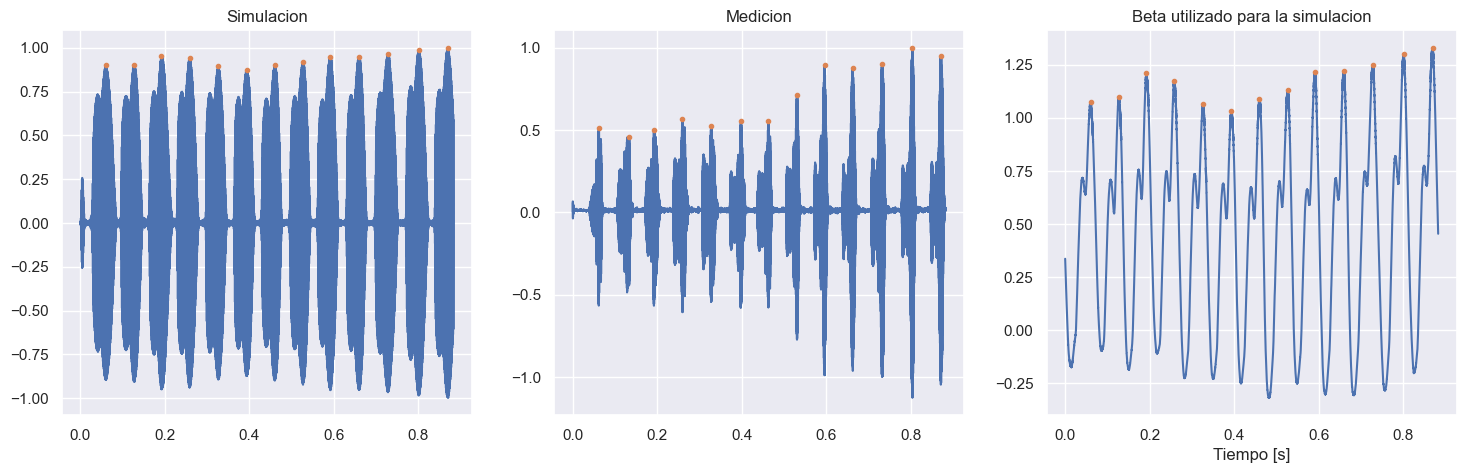

In [560]:

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18,5), sharex=True)

#busco picos
##simulacion
peaks_s, _ = signal.find_peaks(s_s, height = 0.8, prominence = 1, distance = 2e3) #, threshold=0.1)

##medicion
peaks_m, _ = signal.find_peaks(s_m, height = 0.4, distance = 2e3 ) # np.abs(s_s_array/2)) #, threshold=0.1)

## beta
peaks_b, _ = signal.find_peaks(b, height = 0.4, distance = 2e3 ) 

#ploteo

ax1.plot(t, s_s)
ax1.plot(t[peaks_s], s_s[peaks_s], '.')
ax1.set_title('Simulacion')

ax2.plot(t, s_m)
ax2.plot(t[peaks_m], s_m[peaks_m], '.') 
ax2.set_title('Medicion')

ax3.plot(t, b)
ax3.plot(t[peaks_b], b[peaks_b], '.')
ax3.set_title('Beta utilizado para la simulacion')

ax3.set_xlabel('Tiempo [s]')
#print(len(s_s[peaks_s]),len(s_m[peaks_m]), len(s_m[peaks_m])/len(s_s[peaks_s]))

Noto que el sonido está modulado. Me modifica algo?


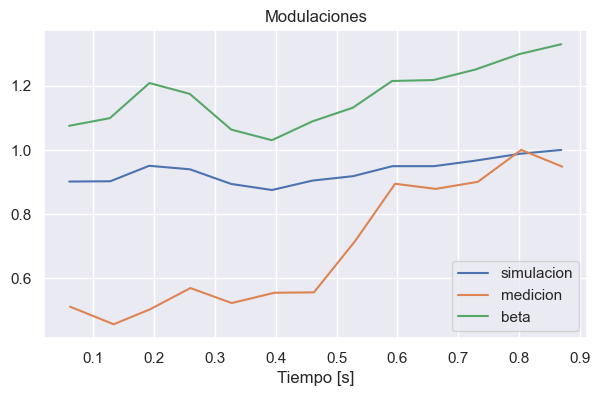

In [562]:
plt.figure(figsize=(7,4))
plt.title('Modulaciones')
plt.plot(t[peaks_s], s_s[peaks_s], label = 'simulacion')
plt.plot(t[peaks_m], s_m[peaks_m], label = 'medicion')
plt.plot(t[peaks_b], b[peaks_b], label = 'beta')
plt.xlabel('Tiempo [s]')
plt.legend()

#### Segunda aproximación: 
el umbral va a estar determinado por la modulación del pulso ($\beta$). Tomo como umbral el 50% de la señal modulada por la fracción de $\beta$

26
[254, 1124, 3555, 4104, 6320, 7071, 9348, 9967, 12152, 12939, 15112, 15923, 18030, 18822, 20896, 21800, 23888, 24691, 26786, 27694, 29757, 30687, 33010, 33909, 36166, 36881]
[1124, 3555, 4104, 6320, 7071, 9348, 9967, 12152, 12939, 15112, 15923, 18030, 18822, 20896, 21800, 23888, 24691, 26786, 27694, 29757, 30687, 33010, 33909, 36166, 36881]


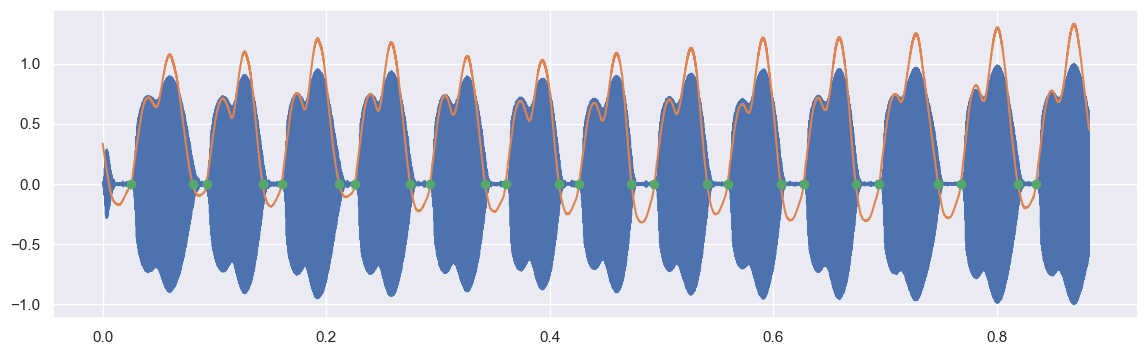

In [20]:
index_split = []
for i in range(len(t)-1):
    if b[i]*b[i+1] < 0:
        #print(f'Cambio de signo en t= {t[i]}')
        index_split.append(i)
print(len(index_split))
print(index_split)
index_split.pop(0)
print(index_split)

plt.figure(figsize=(14,4))
plt.plot(t,s_s)
plt.plot(t,b)
plt.plot(t[index_split], b[index_split], 'o')

In [21]:
#ordeno los datos

pulsos = {i: {'t' : t[index_split[i]:index_split[i+1]],
              's_s': s_s[index_split[i]:index_split[i+1]],
              's_m': s_m[index_split[i]:index_split[i+1]],
              'b': b[index_split[i]:index_split[i+1]]} for i in range(24) if i%2==0 } #ME FALTA EL ULTIMO PULSO
print(len(pulsos))

12


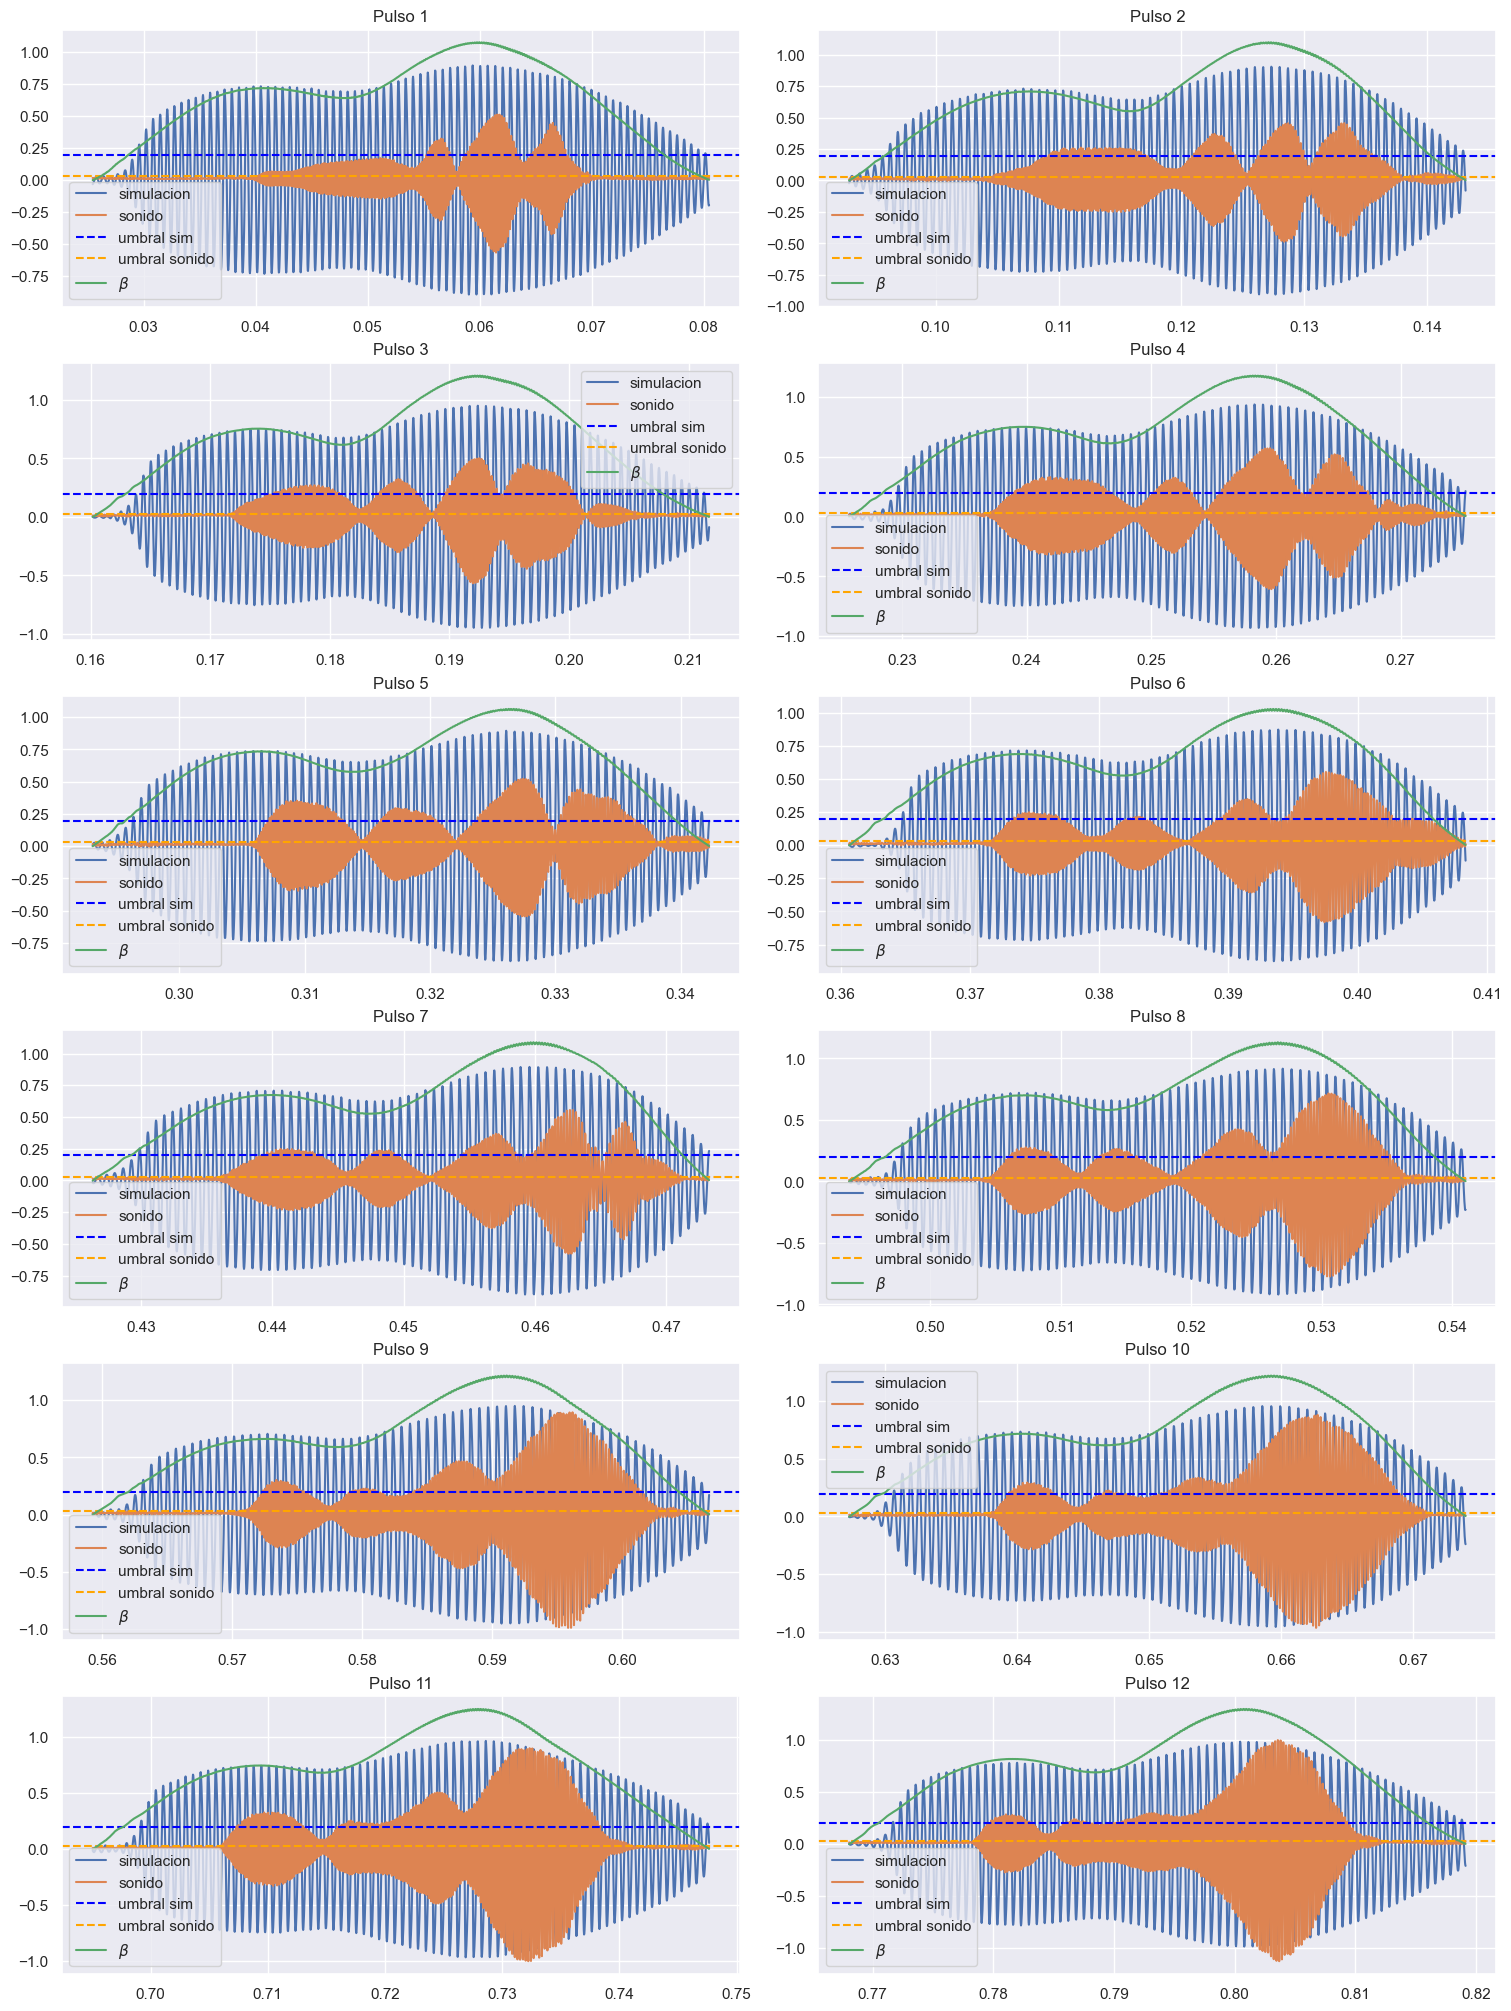

In [22]:
fig, axes = plt.subplots(6, 2, figsize=(15,20), constrained_layout=True, sharey=False)
axs = axes.flatten()

for i,ps in enumerate(pulsos):
    t_ = pulsos[ps]['t']
    s_s_ = pulsos[ps]['s_s']
    s_m_ = pulsos[ps]['s_m']
    b_ = pulsos[ps]['b']
    umbral_s = sigma_s * 5
    umbral_m = sigma_m * 5
    axs[i].plot(t_,s_s_, label = 'simulacion')
    axs[i].plot(t_,s_m_, label = 'sonido')
    axs[i].axhline( umbral_s, label = 'umbral sim', color = 'blue', ls = '--')
    axs[i].axhline( umbral_m, label = 'umbral sonido', color = 'orange', ls = '--')
    axs[i].plot(t_,b_, label = r'$\beta$')
    axs[i].set_title(f'Pulso {i+1}')
    axs[i].legend()
    


<!-- Para determinar el porcentaje de fonación voy a calcular el porcentaje de picos que pasa el umbral -->

Para determinar el porcentaje de fonación voy a calcular el porcentaje de picos que pasan el umbral.

In [54]:
#para elegir el valor en el que dos picos no son consecutivos 
# caclulo el valor medio de la diferencia entre picos 
# tomo el doble de ese valor como cota inferior

tresh = np.mean(np.diff(picos_m)) * 2
print(tresh)

15.581881533101045


In [ ]:
print(index_fon_m)

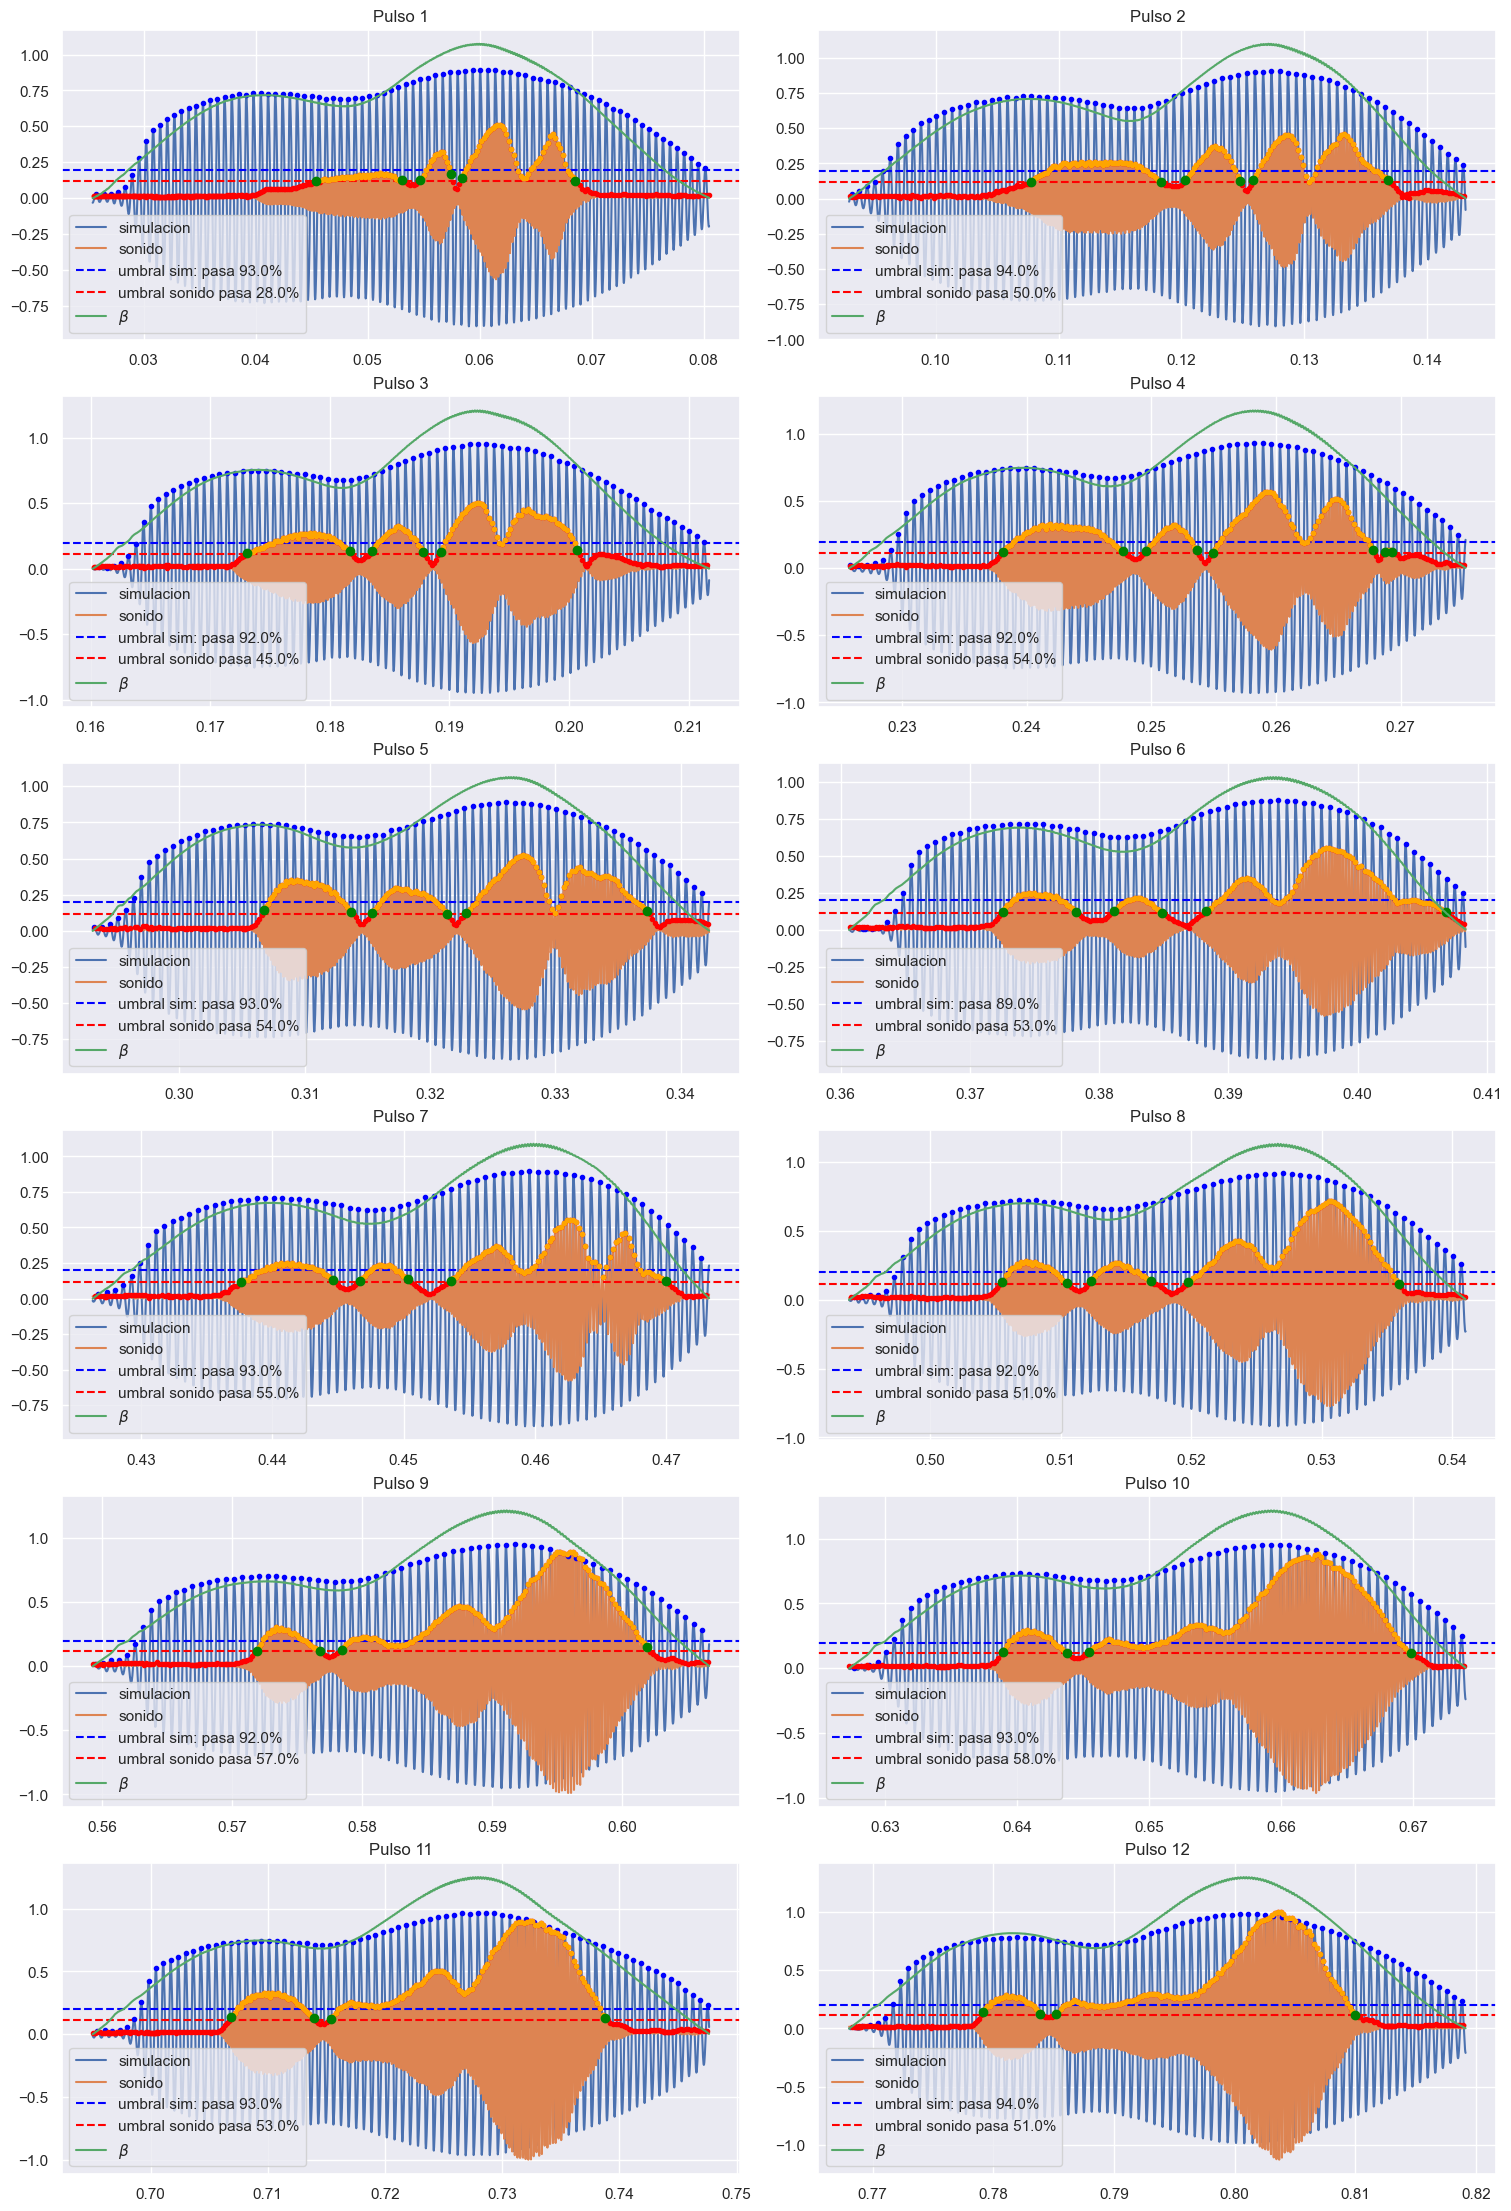

In [64]:
fig, axes = plt.subplots(6, 2, figsize=(15,22), constrained_layout=True, sharey=False)
axs = axes.flatten()


for i,ps in enumerate(pulsos):
    t_ = pulsos[ps]['t']
    s_s_ = pulsos[ps]['s_s']
    s_m_ = pulsos[ps]['s_m']
    b_ = pulsos[ps]['b']
    picos_s, _ = signal.find_peaks(s_s_, height = 0 )  
    picos_m, _ = signal.find_peaks(s_m_, height = 0 )  

    #guardo los indices de los picos
    pulsos[ps]['picos_m'] = picos_m
    
    #umbral de fonacion
    umbral_s = sigma_s * 5
    umbral_m = sigma_m * 20

    #indices de los picos que pasan el umbral
    index_fon_s = [p for p in picos_s if s_s_[p] > umbral_s]
    index_fon_m = [p for p in picos_m if s_m_[p] > umbral_m]

    #fraccion de los picos que pasan el umbral
    fon_s = len(index_fon_s)/ len(picos_s)
    fon_m = len(index_fon_m)/ len(picos_m)

    #indices de los intervalos de fonacion (criterio: que no sean consecutivos)
    index_intervalo_fon_m = [index_fon_m[0]]
    tresh = max(np.diff(picos_m)) * 2 # criterio para determnar si los picos son consecutivos o no
    for j in range(len(index_fon_m)):
        if index_fon_m[j] - index_fon_m[j-1] > tresh:
            index_intervalo_fon_m.append(index_fon_m[j])
        if j < len(index_fon_m)-1:
            if index_fon_m[j+1] - index_fon_m[j] > tresh:
                index_intervalo_fon_m.append(index_fon_m[j])
    index_intervalo_fon_m.append(index_fon_m[-1])
    
    #guardo los indices de los intervalos de fonacion        
    pulsos[ps]['intervalos_fon_m'] = index_intervalo_fon_m
    #print(f'Porcentaje de fonación para el pulso {i+1}:')
    #print(f'Simulación: {fon_s * 100}%')
    #print(f'Medición: {fon_m * 100}%')
    axs[i].plot(t_,s_s_, label = 'simulacion')
    axs[i].plot(t_,s_m_, label = 'sonido')
    axs[i].axhline( umbral_s,label = f'umbral sim: pasa {np.round(fon_s*100)}%', color = 'blue', ls = '--')
    axs[i].axhline( umbral_m,label = f'umbral sonido pasa {np.round(fon_m*100)}%', color = 'red', ls = '--')
    #axs[i].plot(t_, umbral_s, label = f'umbral sim: pasa {np.round(fon_s*100)}%', color = 'blue', ls = '--')
    #axs[i].plot(t_, umbral_m, label = f'umbral sonido pasa {np.round(fon_m*100)}%', color = 'orange', ls = '--')
    axs[i].plot(t_[picos_s], s_s_[picos_s], '.', color = 'blue')
    axs[i].plot(t_[picos_m], s_m_[picos_m], '.', color = 'red')
    axs[i].plot(t_[index_fon_m], s_m_[index_fon_m], '.', color = 'orange')
    axs[i].plot(t_[index_intervalo_fon_m] , s_m_[index_intervalo_fon_m] , 'o', color = 'green')
    axs[i].plot(t_,b_, label = r'$\beta$')
    axs[i].set_title(f'Pulso {i+1}')
    axs[i].legend()

In [83]:
np.where(t==0)

(array([0]),)

#### Armo $f_0$ con los datos de fonación


In [95]:
delta = np.ones(len(t))

for ps in pulsos:
    index_fon = pulsos[ps]['intervalos_fon_m']
    t_ = pulsos[ps]['t']
    for j in range(0,len(index_fon),2):
        t_fon_1 = t_[index_fon[j]]
        t_fon_2 = t_[index_fon[j+1]]
        index_fon_1 = np.where(t == t_fon_1)[0][0]
        index_fon_2 = np.where(t == t_fon_2)[0][0]
        #print(index_fon_1,index_fon_2)
        delta[index_fon_1:index_fon_2] = 0
        


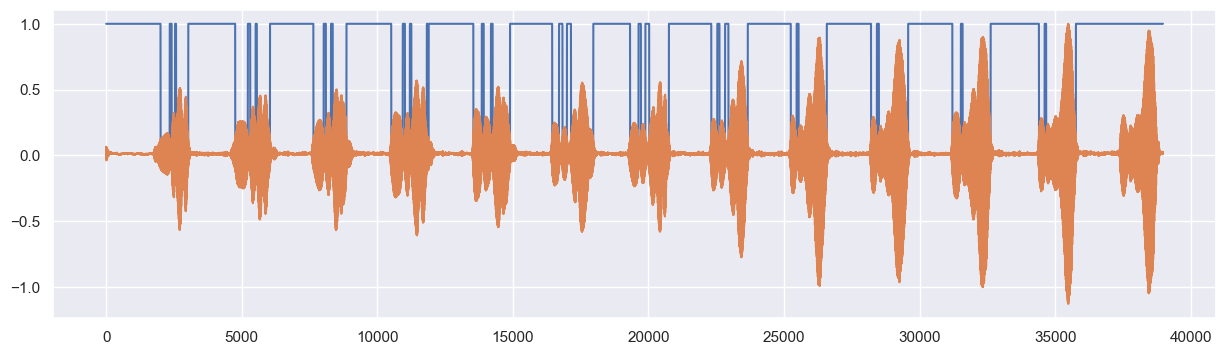

In [94]:
plt.figure(figsize = (15,4))
plt.plot(delta)
plt.plot(s_m)

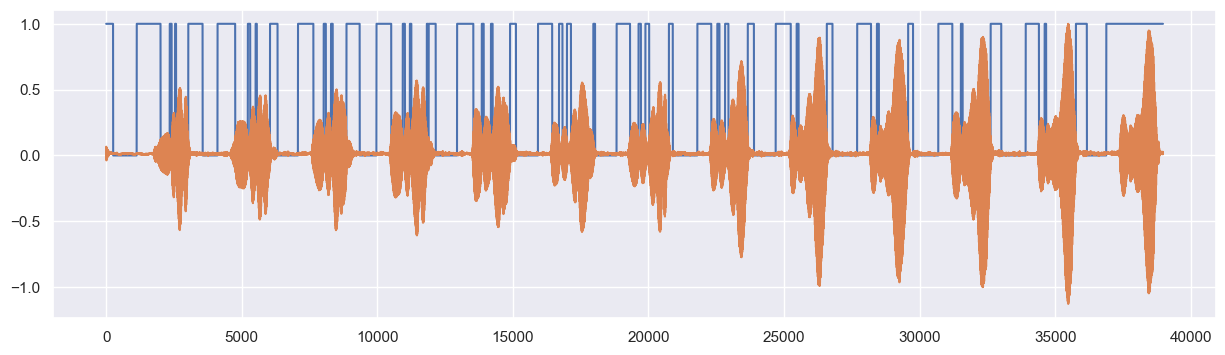

In [96]:
delta[b<0] = 0
plt.figure(figsize = (15,4))
plt.plot(delta)
plt.plot(s_m)

In [97]:
wavfile.write("sonido-presion/delta_segmento_1.wav", fs, delta.astype(np.float32))